True
1
NVIDIA GeForce GTX 1650
Training on device cuda


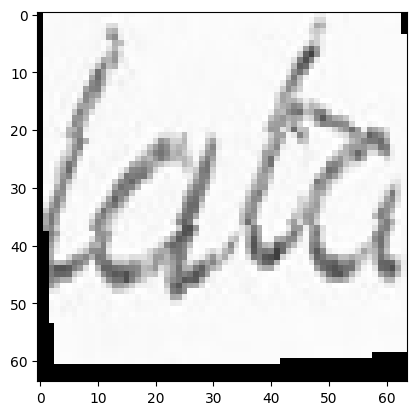

Epoch 1/100, Loss: 7.7036, Val Accuracy: 0.0486, Test Accuracy: 0.0518
Epoch 2/100, Loss: 7.0472, Val Accuracy: 0.0721, Test Accuracy: 0.0664
Epoch 3/100, Loss: 6.7579, Val Accuracy: 0.1057, Test Accuracy: 0.0989
Epoch 4/100, Loss: 6.5165, Val Accuracy: 0.1121, Test Accuracy: 0.1050
Epoch 5/100, Loss: 6.2798, Val Accuracy: 0.1207, Test Accuracy: 0.1204
Epoch 6/100, Loss: 6.0743, Val Accuracy: 0.1336, Test Accuracy: 0.1296
Epoch 7/100, Loss: 5.8508, Val Accuracy: 0.1493, Test Accuracy: 0.1521
Epoch 8/100, Loss: 5.6126, Val Accuracy: 0.1514, Test Accuracy: 0.1507
Epoch 9/100, Loss: 5.3926, Val Accuracy: 0.1693, Test Accuracy: 0.1714
Epoch 10/100, Loss: 5.1735, Val Accuracy: 0.1786, Test Accuracy: 0.1804
Epoch 11/100, Loss: 4.9574, Val Accuracy: 0.1893, Test Accuracy: 0.1904
Epoch 12/100, Loss: 4.7292, Val Accuracy: 0.2007, Test Accuracy: 0.2089
Epoch 13/100, Loss: 4.5033, Val Accuracy: 0.2000, Test Accuracy: 0.2064
Epoch 14/100, Loss: 4.2672, Val Accuracy: 0.2050, Test Accuracy: 0.2075
E

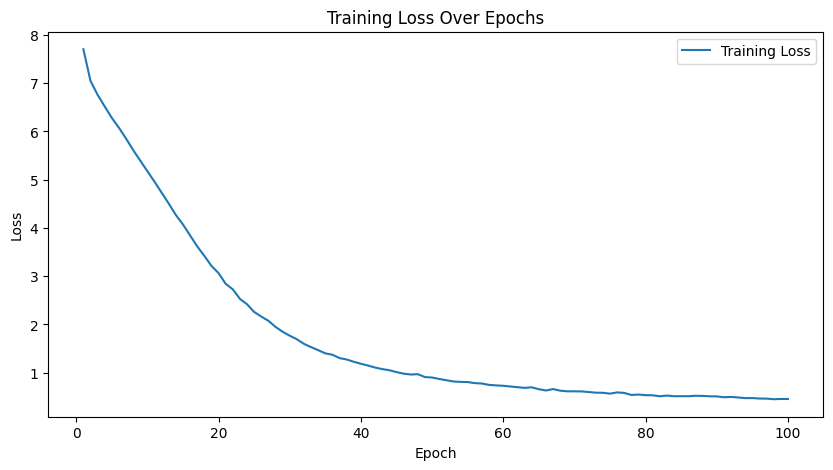

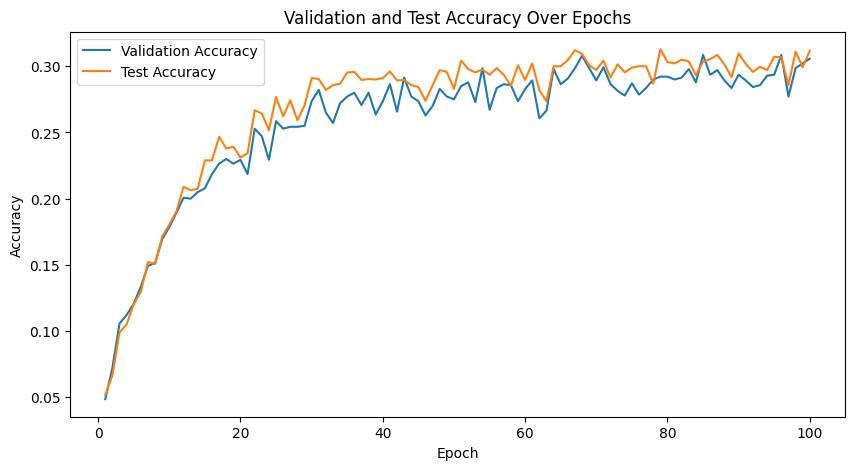

In [ ]:
import pandas as pd
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


print(torch.cuda.is_available())  
print(torch.cuda.device_count())  
print(torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device {device}")


# Constants
CSV_PATH = "hpt_dataset.csv"
IMAGE_SIZE = (64, 64)
BATCH_SIZE = 128
EPOCHS = 100
LEARNING_RATE = 0.001


# Wczytanie danych i kodowanie etykiet
df = pd.read_csv(CSV_PATH)
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['word'])  # Kodowanie etykiet


# Podział danych
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.125, random_state=42)


def load_images_and_labels(dataframe):
    images, labels = [], []
    for _, row in dataframe.iterrows():
        img_path = row['path']
        label = row['label']  
        image = Image.open(img_path).convert('L')
        image = transform(image)
        images.append(image)
        labels.append(label)
    return torch.stack(images), labels


# Przygotowanie danych
train_images, train_labels = load_images_and_labels(train_df)
val_images, val_labels = load_images_and_labels(val_df)
test_images, test_labels = load_images_and_labels(test_df)


mean = train_images.mean()
std = train_images.std()
# Transformacje obrazów (augmentacja)
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomRotation(5),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])


# Konwersja etykiet na tensory i utworzenie datasetów
dataset_train = TensorDataset(train_images, torch.tensor(train_labels, dtype=torch.long))
dataset_val = TensorDataset(val_images, torch.tensor(val_labels, dtype=torch.long))
dataset_test = TensorDataset(test_images, torch.tensor(test_labels, dtype=torch.long))


dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)


# Model
num_classes = len(label_encoder.classes_)
model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(256 * 4 * 4, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes)
)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Dodano L2
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


# Funkcja do obliczania dokładności
def calculate_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total


# Listy do przechowywania wyników
train_losses = []
val_accuracies = []
test_accuracies = []


# Trening modelu
def train_model():
    model.to(device)  # Przeniesienie modelu na GPU
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for images, labels in dataloader_train:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
       
        # Obliczanie straty i dokładności
        avg_loss = total_loss / len(dataloader_train)
        train_losses.append(avg_loss)
       
        # Obliczanie dokładności na zbiorze walidacyjnym i testowym
        val_accuracy = calculate_accuracy(model, dataloader_val)
        test_accuracy = calculate_accuracy(model, dataloader_test)
        val_accuracies.append(val_accuracy)
        test_accuracies.append(test_accuracy)
       
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}, "
              f"Val Accuracy: {val_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
plt.imshow(train_images[0][0].cpu().numpy(), cmap="gray")
plt.show()
train_model()


# Wykres straty treningowej
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()


# Wykres dokładności walidacyjnej i testowej
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), val_accuracies, label="Validation Accuracy")
plt.plot(range(1, EPOCHS + 1), test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation and Test Accuracy Over Epochs")
plt.legend()
plt.show()


